# LASSO and Ridge Regression

This function shows how to use TensorFlow to solve lasso or ridge regression for $\boldsymbol{y} = \boldsymbol{Ax} + \boldsymbol{b}$

We will use the iris data, specifically: $\boldsymbol{y}$ = Sepal Length, $\boldsymbol{x}$ = Petal Width

In [1]:
# import required libraries
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops

In [2]:
# Specify 'Ridge' or 'LASSO'
regression_type = 'LASSO'
# regression_type = 'Ridge'

In [3]:
# clear out old graph
ops.reset_default_graph()

# Create graph
sess = tf.Session()

## Load iris data

In [4]:
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([x[3] for x in iris.data])
y_vals = np.array([y[0] for y in iris.data])

## Model Parameters

In [5]:
# Declare batch size
batch_size = 50

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# make results reproducible
seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare model operations
model_output = tf.add(tf.matmul(x_data, A), b)

## Loss Functions


**ヘビサイド関数を以下の様にして近似している**

\begin{equation}
        h = \frac{1}{1 + \exp\Big(-50\times(A-\text{constant})\Big)} 
\end{equation}


In [6]:
# Select appropriate loss function based on regression type

if regression_type == 'LASSO':
    # Declare Lasso loss function
    # Lasso Loss = L2_Loss + heavyside_step,
    # Where heavyside_step ~ 0 if A < constant, otherwise ~ 99
    lasso_param = tf.constant(0.9)
    heavyside_step = tf.truediv(1.,
                                tf.add(1.,
                                       tf.exp(
                                           tf.multiply(-50.,
                                                       tf.subtract(
                                                           A, lasso_param)))))
    regularization_param = tf.multiply(heavyside_step, 99.)
    loss = tf.add(
        tf.reduce_mean(tf.square(y_target - model_output)),
        regularization_param)
    print("Lasso loss:", loss.shape)

elif regression_type == 'Ridge':
    # Declare the Ridge loss function
    # Ridge loss = L2_loss + L2 norm of slope
    ridge_param = tf.constant(1.)
    ridge_loss = tf.reduce_mean(tf.square(A))
    loss = tf.expand_dims(
        tf.add(
            tf.reduce_mean(tf.square(y_target - model_output)),
            tf.multiply(ridge_param, ridge_loss)),
        0)  # expandするのはLassoとlossの形を同様にするため

else:
    print('Invalid regression_type parameter value', file=sys.stderr)

Lasso loss: (1, 1)


## Optimizer

In [7]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

## Run regression

In [8]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss[0])
    if (i+1)%300==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
        print('Loss = ' + str(temp_loss))
        print('\n')

Step #300 A = [[0.77170753]] b = [[1.8249986]]
Loss = [[10.26473]]


Step #600 A = [[0.7590854]] b = [[3.2220633]]
Loss = [[3.0629203]]


Step #900 A = [[0.74843585]] b = [[3.9975822]]
Loss = [[1.2322046]]


Step #1200 A = [[0.73752165]] b = [[4.429741]]
Loss = [[0.57872057]]


Step #1500 A = [[0.7294267]] b = [[4.672531]]
Loss = [[0.40874982]]




## Extract regression results

In [9]:
# Get the optimal coefficients
[slope] = sess.run(A)
[y_intercept] = sess.run(b)

# Get best fit line
best_fit = []
for i in x_vals:
    best_fit.append(slope*i+y_intercept)

## Plot results

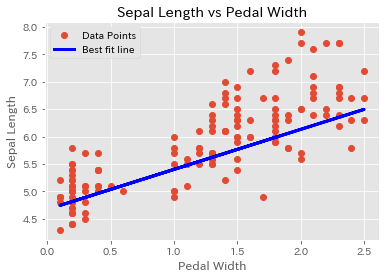

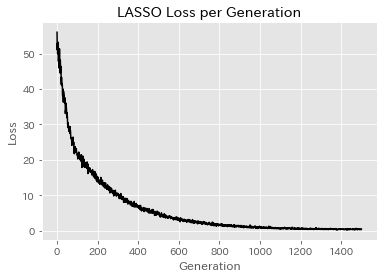

In [10]:
%matplotlib inline
plt.style.use("ggplot")
# Plot the result
plt.plot(x_vals, y_vals, 'o', label='Data Points')
plt.plot(x_vals, best_fit, 'b-', label='Best fit line', linewidth=3)
plt.legend(loc='upper left')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title(regression_type + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()